In [110]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import kwant

import tinyarray

import lmfit as lmf

import scipy.linalg as lin

from tqdm import tqdm
import pickle

from scipy import stats

import warnings

In [111]:
tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])
tau_0 = tinyarray.array([[1, 0], [0, 1]])

def Lorentzian(eex, ee, gam):
    return (gam/np.pi)*(1/((eex-ee)**2 + gam**2))

def Fermi(eps, beta = 20000):
    return 1/(1+np.exp(beta*eps))

In [112]:
Fibonacci_number = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657]
tau_approximant = [1, 2.0, 1.5, 1.6666666666666667, 1.6, 1.625, 1.6153846153846154, 1.619047619047619, 1.6176470588235294, 1.6181818181818182, 1.6179775280898876, 1.6180555555555556, 1.6180257510729614, 1.6180371352785146, 1.618032786885246, 1.618034447821682, 1.6180338134001253, 1.618034055727554, 1.6180339631667064, 1.6180339985218033, 1.618033985017358, 1.6180339901755971]

In [113]:
class Fibonacci_chains:
    def __init__(self):
        self.Fibonacci_cellar = {}
    
    def get_chain(self,n,j):
        if j>=n:
            warnings.warn("phi greater than 2 pi. Using modulo 2 pi.")
            j = j%n
        try:
            chain = self.Fibonacci_cellar[(n,j)]
        except KeyError:
            N = Fibonacci_number[n]
            phi = 2*np.pi*j/N
            chain = ["A" if np.sign(np.cos(2*np.pi*m*(1/tau) + phi) - np.cos(np.pi*(1/tau)))>=0 else "B" for m in range(N)]
            self.Fibonacci_cellar[(n,j)] = chain
        return chain

FCs = Fibonacci_chains()

In [121]:
class TBmodel:
    def __init__(self, LL, ts, us, vs):
        self.LL = LL
        self.a = 1
        self.ts, self.us, self.vs = ts, us, vs
        self.Delta = np.array([1]*self.LL)
        self.Pot = np.zeros(self.LL)

    def onsite(self, site, Delta, Pot):
        (x,y) = site.tag
        return (self.us[x]+Pot[x])*tau_z - self.vs[x]*Delta[x]*tau_x
    
    def hopping(self,site1,site2):
        (x2,y2) = site2.tag
        (x1,y1) = site1.tag
        return self.ts[x1]*tau_z
    
    def make_syst(self):
        self.syst = kwant.Builder()
        self.lat = kwant.lattice.square(self.a, norbs = 2)
        
        self.syst[(self.lat(x,0) for x in range(self.LL))] = self.onsite
        self.syst[((self.lat(x+1,0),self.lat(x,0)) for x in range(self.LL-1))] = self.hopping
        self.syst[((self.lat(0,0), self.lat(self.LL-1,0)))] = self.hopping
        
        self.fsyst = self.syst.finalized()
        return

    def solve(self,H):
        (evals, evecs) = lin.eigh(H)
    
        uvecs = evecs[::2]
        vvecs = evecs[1::2]
        
        return (evals[self.LL:],uvecs[:,self.LL:],vvecs[:,self.LL:])

    def iterate(self):
        def self_cons(H):
            (evals, uvecs, vvecs) = self.solve(H)
            self.evals, self.uvecs, self.vvecs = (evals, uvecs, vvecs)
            
            Delta = np.zeros(self.LL, dtype = "complex128")
            for ee, uvec, vvec in zip(evals, uvecs.T, vvecs.T):
                Delta += (1-2*Fermi(ee, beta = self.beta))*uvec*vvec.conjugate()
            
            occupancy = np.zeros(self.LL)
            for ee, uvec, vvec in zip(evals, uvecs.T, vvecs.T):
                    occupancy += Fermi(ee, beta = self.beta)*2*np.abs(vvec)**2 + (1-Fermi(ee))*2*np.abs(uvec)**2
            
            Pot = 1/2*self.vs*occupancy
            Pot = Pot + 0.0001*np.ones(len(Pot))

            return (Delta, Pot)
        
        err_Delta = np.ones(1)
        cc = 0
        
#         while any([err/Del>0.001 and err>0.01*(np.max(self.Delta)+0.01) for err,Del in zip(err_Delta, self.Delta)]):
        for _ in range(20):
            H = self.fsyst.hamiltonian_submatrix(params = dict(Delta = self.Delta, Pot = self.Pot))
            newDelta, newPot = self_cons(H)
            err_Delta = np.abs(newDelta - self.Delta)
            
            cc += 1    
            self.Delta, self.Pot = newDelta, newPot
        
        print("Convergence took {} iterations".format(cc))
        
        self.H = H
        return self.Delta, self.Pot
        
    
    def get_DOS(self, gam = None, Num_es = 1000):
        emax = np.max(np.abs(self.evals))
        
        if gam == None:
            gam = 2*emax/self.LL
            
        eex = np.linspace(-1.2*emax,1.2*emax, Num_es)
        DOSu = np.zeros(eex.shape)
        DOSv = np.zeros(eex.shape)
        
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            if ee>0:
                DOSu += np.linalg.norm(uvec)**2*Lorentzian(eex,ee,gam) 
                DOSv += np.linalg.norm(vvec)**2*Lorentzian(eex,-ee,gam)
                
        self.DOS = (DOSu + DOSv)/self.LL
        return  self.DOS , eex
    
    def get_LDOS(self, gam = None, Num_es = 1000):
        emax = np.max(np.abs(self.evals))
        
        if gam == None:
            gam = 2*emax/self.LL
            
        eex = np.linspace(-1.2*emax,1.2*emax, Num_es)
        DOSu = np.zeros((self.uvecs.shape[0],eex.shape[0]))
        DOSv = np.zeros(DOSu.shape)
        
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            if ee>0:
                DOSu += (np.abs(uvec)**2)[:,np.newaxis]*Lorentzian(eex,ee,gam)
                DOSv += (np.abs(vvec)**2)[:,np.newaxis]*Lorentzian(eex,-ee,gam)      
            
        self.LDOS = (DOSu + DOSv)/self.LL
        return  self.LDOS,eex

In [122]:
class simple_ring(TBmodel):
    def __init__(self, chain, t_int = -1, beta = 2000):
        self.chain = chain
        self.NN = chain["N"]
        self.beta = beta
        
        ts = np.concatenate((chain["t"],np.array([t_int])))
        us = np.array(chain["u"])
        vs = np.array(chain["v"])
        
        TBmodel.__init__(self, self.NN, ts, us, vs)

        self.make_syst()        
        self.iterate()

In [128]:
def chainFC(n = 3, t=-1, w = 0.1, phi = 0, u = 0, v = 0, wu = 0, wv = 0):
    L = Fibonacci_number[n]
    tau = tau_approximant[n]
    FC = FCs.get_chain(n,phi)
    
    wa = 2*w/(1+tau)
    wb = tau*wa

    ts = [1-wa if letter =="A" else 1+wb for letter in FC]
    chain = {
        "N": L+1,
        "t": -np.array(ts),
        "u" : u - wu/2 + wu*np.random.rand(L+1),
        "v" : v - wv/2 + wv*np.random.rand(L+1)
    }
    return chain

In [147]:
test = simple_ring(chainFC(n = 10,v = 1.5, u = -0.75,w = 0.1))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


Convergence took 20 iterations


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


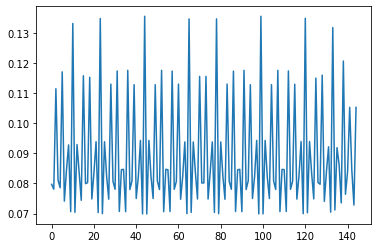

In [148]:
plt.plot(test.Delta)

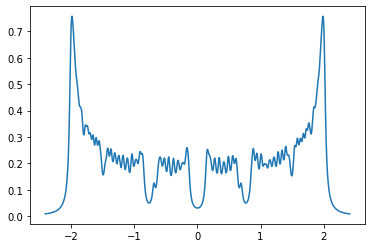

In [150]:
DOS, eex = test.get_DOS()
plt.plot(eex, DOS)